In [12]:
import os
import numpy as np
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (25, 25)

red = [255,0,0]

# Get images and labels
X_set = []
y_set = []
for filename in os.listdir('train-data/marked'):
    X_set.append(imread(f'train-data/cleaned/{filename}', as_gray=True))

    marked = imread(f'train-data/marked/{filename}')
    label_indices = np.where(np.all(marked == red, axis=2))
    labels = np.zeros((500,1000))
    labels[label_indices] = 1
    y_set.append(labels)

X_set = np.asarray(X_set)
y_set = np.asarray(y_set)
images = X_set
corners = y_set

window_size = 21
offset = int((window_size-1)/2)

shape = np.shape(X_set)
padded_X_set = np.zeros((shape[0], shape[1]+2*offset, shape[2]+2*offset))
padded_X_set[:, offset:shape[1]+offset, offset:shape[2]+offset] = X_set
print(np.shape(padded_X_set))

new_X_set = []
for i, img in enumerate(y_set):
    rows = []
    for j, row in enumerate(img):
        if offset < j < shape[1]+offset:
            cols = []
            for k, val in enumerate(row):
                if offset < k < shape[2]+offset:
                    cols.append(padded_X_set[i, j-offset-1:j+offset, k-offset-1:k+offset])
            rows.append(cols)
    new_X_set.append(rows)

X_set = np.asarray(new_X_set)
print(np.shape(X_set))

(4, 520, 1020)
(4, 489, 989, 21, 21)


In [23]:
# Split into train and test set
split_index = 3
X_train = np.reshape(X_set[:split_index], (-1, window_size, window_size))
X_test = np.reshape(X_set[split_index:], (-1, window_size, window_size))
y_train = y_set[:split_index, :489, :989].flatten()
y_test = y_set[split_index:, :489, :989].flatten()
print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

(1450863, 21, 21)
(483621, 21, 21)
(1450863,)
(483621,)


In [38]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers

model = models.Sequential()
model.add(layers.Flatten(input_shape=[window_size, window_size]))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 441)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 442       
                                                                 
Total params: 442
Trainable params: 442
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
45340/45340 [==============================] - 20s 445us/step - loss: 0.0000e+00 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 0.9999
Epoch 2/30
45340/45340 [==============================] - 20s 435us/step - loss: 0.0000e+00 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 0.9999
Epoch 3/30
45340/45340 [==============================] - 20s 434us/step - loss: 0.0000e+00 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 0.9999
Epoch 4/30
45340/45340 [==============================] - 20s 434us/step - loss: 0.0000e+00 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 0.9999
Epoch 5/30
45340/45340 [==============================] - 20s 433us/step - loss: 0.0000e+00 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 0.9999
Epoch 6/30
45340/45340 [==============================] - 20s 437us/step - loss: 0.0000e+00 - accuracy: 0.9998 - val_loss: 0.0000e+00 - val_accuracy: 0.9999
Epoch 7/30
45340/45340 [==============================] - 

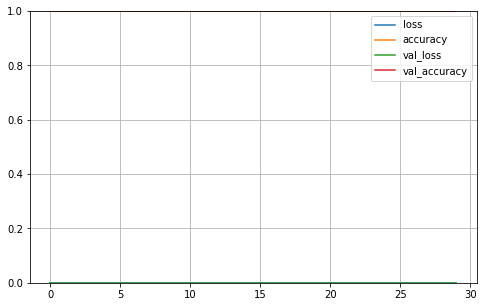

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

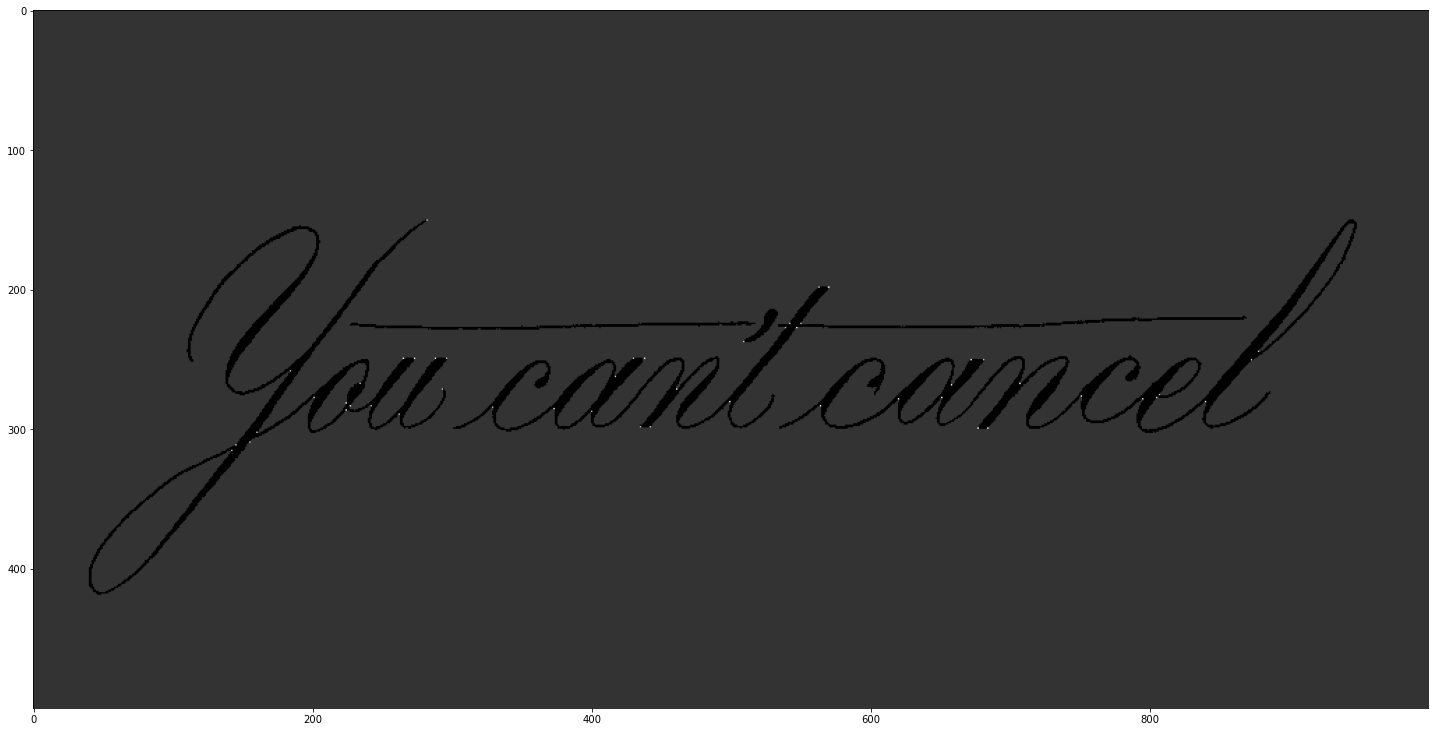

In [27]:
plt.imshow(images[split_index], cmap='gray')
plt.imshow(corners[split_index], cmap='gray', alpha=0.8)

(483621, 1)
0.0
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


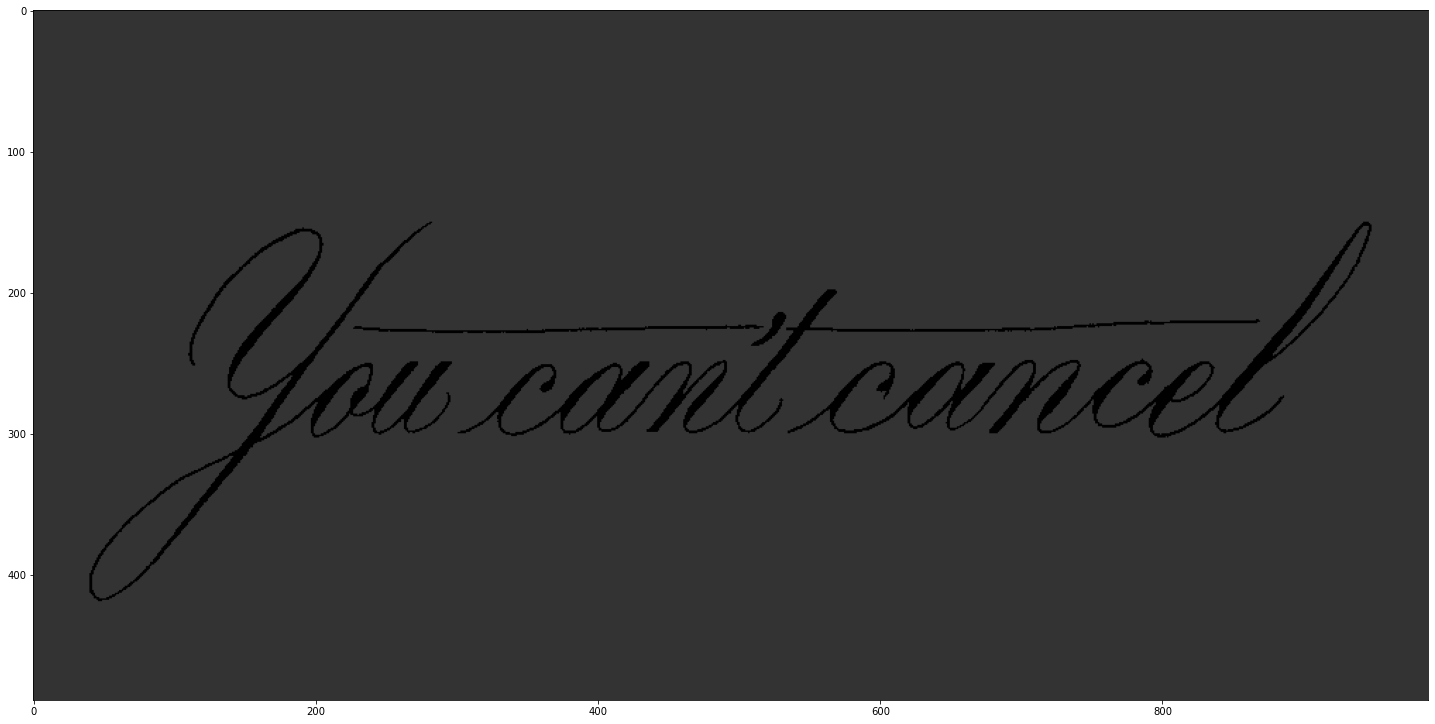

In [41]:
plt.imshow(images[split_index], cmap='gray')
y_pred = model.predict(X_test)
print(np.shape(y_pred))
print(np.sum(y_pred))
print(y_pred)
plt.imshow(np.reshape(y_pred, (489, 989)), cmap='gray', alpha=0.8)

In [ ]:
model.evaluate(X_test, y_test)